In [1]:
import pysam
import os
import glob
from genepeeks.common import utilities as util
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import tabletext
import pickle
# %pdb
# from scipy.stats import poisson

INFO:config:Using ini file set by environment: /home/ec2-user/config/genepeeks.ini


#### Get DMD exons

In [2]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=500, include_index=True)
exon_labels = ['Ex' + exon['index'] for exon in DMD_exons_merged]
print len(DMD_exons_merged), [exon['index'] for exon in DMD_exons_merged if not exon['index'].isdigit()]

Finished loading ensembl within the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 0.17 sec
76 ['44|45', '48|49', '65|66']


#### How close together do 2 exons have to be before we merge them? Currently using 500bp

In [24]:
for i in range(2, 24):
    min_dist = i * 50
    new_DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=min_dist, include_index=True)
    print min_dist, len(new_DMD_exons_merged), [exon['index'] for exon in new_DMD_exons_merged if not exon['index'].isdigit()]

100 79 []
150 78 ['65|66']
200 78 ['65|66']
250 78 ['65|66']
300 78 ['65|66']
350 77 ['44|45', '65|66']
400 76 ['44|45', '48|49', '65|66']
450 76 ['44|45', '48|49', '65|66']
500 76 ['44|45', '48|49', '65|66']
550 76 ['44|45', '48|49', '65|66']
600 76 ['44|45', '48|49', '65|66']
650 75 ['21|22', '44|45', '48|49', '65|66']
700 73 ['9|10', '21|22', '44|45', '48|49', '65|66', '69|70']
750 73 ['9|10', '21|22', '44|45', '48|49', '65|66', '69|70']
800 73 ['9|10', '21|22', '44|45', '48|49', '65|66', '69|70']
850 73 ['9|10', '21|22', '44|45', '48|49', '65|66', '69|70']
900 71 ['4|5', '9|10', '21|22', '39|40', '44|45', '48|49', '65|66', '69|70']
950 71 ['4|5', '9|10', '21|22', '39|40', '44|45', '48|49', '65|66', '69|70']
1000 70 ['4|5', '9|10', '21|22', '39|40', '44|45', '48|49', '55|56', '65|66', '69|70']
1050 70 ['4|5', '9|10', '21|22', '39|40', '44|45', '48|49', '55|56', '65|66', '69|70']
1100 70 ['4|5', '9|10', '21|22', '39|40', '44|45', '48|49', '55|56', '65|66', '69|70']
1150 68 ['4|5', '7

#### Get subject insert lengths across the subject's entire X chromosome, to allow for normalizing each insert length by subject

In [4]:
def get_all_subject_insert_lengths(aligned_bamfile):
    full_bam_insert_lengths = []
    for read in aligned_bamfile.fetch('X'):
        if read.is_read1 and not read.is_unmapped and read.mapping_quality == 60 and not read.mate_is_unmapped and read.is_proper_pair:
            insert_length = read.template_length
            if read.is_reverse == read.mate_is_reverse:
                continue
            elif read.is_reverse:
                orientation = 'RF'
                insert_length *= -1
            else:
                orientation = 'FR'

            if insert_length < 0:
                continue
            full_bam_insert_lengths.append(insert_length)
    return full_bam_insert_lengths

#### Determine which exon the read pair overlaps with, if any

In [75]:
def get_exon_num(pair_start, pair_end, skipped_counts):
    exon_num = None
    for i, exon in enumerate(DMD_exons_merged):
        if exon['end'] <= pair_start:
            continue
        else:
            if exon['start'] < pair_end:
                # Only associate read pairs to an exon that they share at least 20 bp overlap with.
                # Is 20bp the right minimum amount of required overlap?
                overlap = min(exon['end'], pair_end) - max(exon['start'], pair_start)
                if overlap < 20:
                    util.add_to_dict(skipped_counts, 'less_than_20_bp_overlap')
#                     print pair_start, insert_length, pair_end, overlap, exon
                    continue

                # For a merged exon, skip read pairs that only exist within the intron between the 2 exons
                if not exon['index'].isdigit():
                    exon1_i, exon2_i = map(int, exon['index'].split('|'))
                    gap_start = DMD_exons[exon1_i - 1]['end']
                    gap_end = DMD_exons[exon2_i - 1]['start']
                    true_overlap = max(gap_start - pair_start, pair_end - gap_end)
                    if true_overlap <= 10:
                        util.add_to_dict(skipped_counts, 'in_between_joined_exons')
                        break
#                         print pair_start, insert_length, pair_end, true_overlap, exon, gap_start, gap_end

                exon_num = i
                # If not already in the last exon, check if the read pair falls in the next exon as well.
                if exon_num != (len(DMD_exons_merged) - 1):
                    next_exon = DMD_exons_merged[i + 1]
                    if next_exon['start'] < pair_end:
                        util.add_to_dict(skipped_counts, 'in_two_exons')
                        # Skip the read pair if it falls in both exons
                        exon_num = None
            else:
                util.add_to_dict(skipped_counts, 'outside_of_exon')
            break
    return exon_num

#### Parse subject bamfiles. Retrieve all read pair insert lengths within each exon of DMD, and normalize against median and IQR of that subject's insert lengths across the entire X chromosome. In the first parse, use this distribution of normalized insert lengths to calculate 99% cutoffs for each exon. In the second parse, calculate how many read pairs in each exon have insert lengths beyond the expected cutoff. Then compare this observed number of outliers to the poisson expectation to determine its significance.

In [100]:
# bam_files_folder = '../../library_files/inputs/bam_files'
def parse_subject_insert_lengths(first_parse=True, exon_norm_cutoffs=None, subj_name_filter=None):
    if subj_name_filter:
        print 'Filtering for just subjects with {} in their name'.format(subj_name_filter)
    skipped_counts = {}
    subject_count = 0
    if first_parse:
        exon_norm_insert_lengths = [[] for i in xrange(len(DMD_exons_merged))]
    else:
        if exon_norm_cutoffs is None or len(exon_norm_cutoffs) != len(DMD_exons_merged):
            util.stop_err('exon_norm_cutoffs, {}, must be same length as DMD_exons_merged, {}'.format(
                len(exon_norm_cutoffs) if exon_norm_cutoffs else None, len(DMD_exons_merged)), raise_err=False)
        
        # Get headers for subject_contingency_table
        headers = ['subject', 'date_modified', 'full_bam_paired_read_count', 'full_bam_25%', 'full_bam_median', 'full_bam_75%']
        # exon_fields = ['total', 'lower_outl', 'lower_poisson', 'upper_outl', 'upper_poisson']
        exon_fields = ['total', 'lower_outl', 'upper_outl']
        headers += ['{}_{}'.format(exon_label, field) for exon_label in exon_labels for field in exon_fields]        
        subject_contingency_table = [headers]
    
    for root, dirs, files in os.walk('/mnt/vep/subjects'):
        if root.endswith('re86'):
            continue

        for file_name in files:
            if file_name.endswith('.bam'):
                # Can filter for only certain subjects if requested
                if subj_name_filter is not None and subj_name_filter not in file_name:
                    continue
                # The following subject does not have legit data
                if 'FPWB-0001-0309' in file_name:
                    continue
                if '{}.bai'.format(file_name) not in files:
                    print '{} is missing an index file'.format(file_name)
                    continue

                file_path = os.path.join(root, file_name)
                date_modified = os.path.getmtime(file_path)
                if first_parse and date_modified < 1465401045:
                    util.add_to_dict(skipped_counts, 'bam_file_too_old')
                    continue

                subject = os.path.splitext(file_name)[0]
                bamfile = pysam.AlignmentFile(file_path, "rb")
                full_bam_insert_lengths = get_all_subject_insert_lengths(bamfile)

                # First, get median and iqr range of bam file to normalize insert lengths
                bam_median = np.median(full_bam_insert_lengths)
                bam_upper_iqr = np.percentile(full_bam_insert_lengths, 75)
                bam_lower_iqr = np.percentile(full_bam_insert_lengths, 25)
                bam_iqr_size = bam_upper_iqr - bam_lower_iqr
                if not first_parse:
                    # In second parse, get upper and lower cutoffs for each subject to count
                    # the number of insert lengths that are outliers
                    exon_outl_counts = [[0, 0, 0] for i in range(len(DMD_exons_merged))]

                bamfile = pysam.AlignmentFile(file_path, "rb")            
                for read in bamfile.fetch('X', start=31137345, end=33229636):
                    if read.is_read1 and not read.is_unmapped and read.mapping_quality == 60 and not read.mate_is_unmapped and read.is_proper_pair:
                        insert_length = read.template_length
                        if read.is_reverse == read.mate_is_reverse:
                            util.add_to_dict(skipped_counts, 'tandem_pair')
                            continue
                        elif read.is_reverse:
                            orientation = 'RF'
                            insert_length *= -1
                        else:
                            orientation = 'FR'

                        if insert_length <= 0:
                            util.add_to_dict(skipped_counts, 'negative_insert_length')
                            continue

                        # Determine which exon the read pair overlaps with, if any
                        pair_start = min(read.reference_start, read.next_reference_start)
                        pair_end = pair_start + insert_length
                        exon_num = get_exon_num(pair_start, pair_end, skipped_counts)
                        if exon_num is None:
                            continue

                        # Normalize insert length for each subject by subtracting the subject's median insert length
                        # and dividing by the IQR for the subject
                        norm_insert_length = (insert_length - bam_median) / float(bam_iqr_size)
                        if first_parse:
                            # On the first parse, store all normalized insert lengths for each exon,
                            # to allow for calculation of what will constitute an outlier for any exon
                            exon_norm_insert_lengths[exon_num].append(norm_insert_length)
                        else:
                            # On the second parse, check if normalized insert length is beyond the exon's cutoff point,
                            # and keep track of the number of outliers on both the low and high ends
                            exon_outl_counts[exon_num][0] += 1
                            if norm_insert_length < exon_norm_cutoffs[exon_num][0]:
                                exon_outl_counts[exon_num][1] += 1
                            elif norm_insert_length > exon_norm_cutoffs[exon_num][1]:
                                exon_outl_counts[exon_num][2] += 1
                                            
                if not first_parse:
                    # Begin with the overall subject data, and create contingency table
                    # by looking at each subject's number of insert length outliers in each exon
                    subject_data = [subject, date_modified, len(full_bam_insert_lengths), bam_lower_iqr, bam_median, bam_upper_iqr]
                    subject_data += list(itertools.chain(*exon_outl_counts))
                    # Commented out the poisson code for now since scipy.stats cannot be imported on the amazon instance
#                     for total, lower, upper in exon_insert_lengths:
#                         expected = total * cutoff_fraction
#                         lower_poisson = 1 - poisson.cdf(lower, expected)
#                         upper_poisson = 1 - poisson.cdf(upper, expected)
#                         subject_data += [total, lower, lower_poisson, upper, upper_poisson]
                    

                    if len(subject_data) != len(headers):
                        util.stop_err('Unequal length of headers vs subject_data: {} vs {}'.format(len(subject_data), len(headers)))
                    subject_contingency_table.append(subject_data)
                subject_count += 1
                if subject_count % 5 == 0:
                    print 'Finished parsing {} subjects'.format(subject_count)

    # Print counts of skipped reads
    print 'Finished parsing all {} subjects in the {} parse'.format(subject_count, 'first' if first_parse else 'second')
    for k, v in skipped_counts.items():
        print k, v
    return exon_norm_insert_lengths if first_parse else subject_contingency_table

#### Do first parse of subject insert lengths to get all normalized insert lengths for each exon across all subjects. Use this data to determine normalized outlier cutoffs for each exon

In [101]:
%%time
# testing_data = parse_subject_insert_lengths(first_parse=True, subj_name_filter='FRMR-00SC-714V')
# exon_norm_insert_lengths = parse_subject_insert_lengths(first_parse=True, subj_name_filter='RMR')
all_exon_norm_insert_lengths = parse_subject_insert_lengths(first_parse=True)

# Get cutoffs for each exon, and dump list to a pickle
exon_norm_cutoffs = [(np.percentile(norm_insert_lengths, 1), np.percentile(norm_insert_lengths, 99))
                    for norm_insert_lengths in all_exon_norm_insert_lengths]
with open('exon_norm_cutoffs.pickle', 'wb') as handle:
    pickle.dump(exon_norm_cutoffs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Finished parsing 5 subjects
Finished parsing 10 subjects
Finished parsing 15 subjects
Finished parsing 20 subjects
Finished parsing 25 subjects
Finished parsing 30 subjects
Finished parsing 35 subjects
Finished parsing 40 subjects
Finished parsing 45 subjects
Finished parsing 50 subjects
Finished parsing 55 subjects
Finished parsing 60 subjects
Finished parsing 65 subjects
FK2R-0000-151I.bam is missing an index file
Finished parsing 70 subjects
Finished parsing 75 subjects
Finished parsing 80 subjects
Finished parsing 85 subjects
Finished parsing 90 subjects
Finished parsing 95 subjects
Finished parsing 100 subjects
Finished parsing 105 subjects
Finished parsing 110 subjects
Finished parsing 115 subjects
Finished parsing 120 subjects
Finished parsing 125 subjects
Finished parsing 130 subjects
Finished parsing 135 subjects
Finished parsing 140 subjects
Finished parsing 145 subjects
Finished parsing 150 subjects
Finished parsing 155 subjects
Finished parsing 160 subjects
Finished parsing

#### Also load exon normalized cutoffs to csv for easier plotting with pandas

In [110]:
cutoffs = [(exon_labels[i], len(norm_insert_lengths), np.percentile(norm_insert_lengths, 1), np.percentile(norm_insert_lengths, 99))
           for i, norm_insert_lengths in enumerate(exon_norm_insert_lengths)]

cutoffs.insert(0, ('Exon', 'read_pair_count', 'lower_cutoff', 'upper_cutoff'))
exon_norm_cutoffs_df = pd.DataFrame(cutoffs)
exon_norm_cutoffs_df.to_csv("../exon_data/exon_norm_cutoffs.csv")

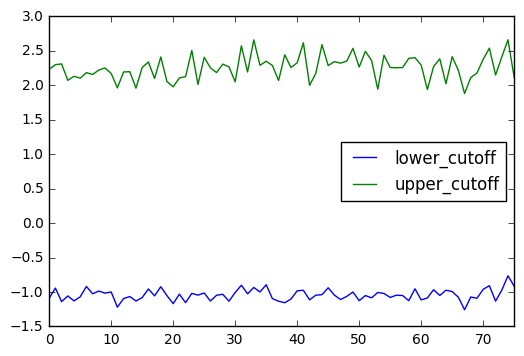

In [113]:
exon_norm_cutoffs_df = pd.read_csv("../exon_data/exon_norm_cutoffs.csv", header=1)
for item in exon_norm_cutoffs_df.columns[3:]:
    exon_norm_cutoffs_df[item].plot()
plt.legend(loc='best')

In [103]:
wanted_percentiles = [1, 5, 25, 50, 75, 95, 99]
headers = ['Exon', 'Count'] + ['{}%'.format(perc) for perc in wanted_percentiles]
exon_norm_table = [headers]
# cutoff_fraction = 0.01
# cutoff_percent = 100.0 * cutoff_fraction
for i, norm_insert_lengths in enumerate(exon_norm_insert_lengths):    
    exon_stats = [np.percentile(norm_insert_lengths, perc) for perc in wanted_percentiles]
    exon_norm_table.append([exon_labels[i], len(norm_insert_lengths)] + [round(item, 4) for item in exon_stats])
#     print exon_labels[exon_num], len(norm_insert_lengths), np.percentile(norm_insert_lengths, 1), np.percentile(norm_insert_lengths, 99)
print tabletext.to_text(exon_norm_table)

┌─────────┬────────┬─────────┬─────────┬─────────┬─────────┬────────┬────────┬────────┐
│ Exon    │ Count  │ 1%      │ 5%      │ 25%     │ 50%     │ 75%    │ 95%    │ 99%    │
├─────────┼────────┼─────────┼─────────┼─────────┼─────────┼────────┼────────┼────────┤
│ Ex1     │ 126604 │ -1.0909 │ -0.8273 │  -0.386 │  0.0982 │ 0.6854 │ 1.6293 │ 2.2325 │
├─────────┼────────┼─────────┼─────────┼─────────┼─────────┼────────┼────────┼────────┤
│ Ex2     │  20905 │  -0.943 │ -0.7174 │ -0.3148 │    0.18 │ 0.7267 │ 1.6266 │    2.3 │
├─────────┼────────┼─────────┼─────────┼─────────┼─────────┼────────┼────────┼────────┤
│ Ex3     │  46888 │ -1.1394 │ -0.8571 │ -0.4054 │  0.0759 │ 0.7173 │ 1.6612 │ 2.3113 │
├─────────┼────────┼─────────┼─────────┼─────────┼─────────┼────────┼────────┼────────┤
│ Ex4     │  72809 │ -1.0577 │ -0.7551 │ -0.2645 │  0.2288 │ 0.7122 │ 1.4909 │ 2.0725 │
├─────────┼────────┼─────────┼─────────┼─────────┼─────────┼────────┼────────┼────────┤
│ Ex5     │  32450 │  -1.129 │ -

#### Do second parse of subject insert lengths to create subject contingency table counting number of insert lengths that are outliers for each subject within each exon

In [105]:
%%time
# subj_contingency_table = parse_subject_insert_lengths(first_parse=False, exon_norm_cutoffs=exon_norm_cutoffs, subj_name_filter='FRMR-00SC-714V')
initial_contingency_table_full = parse_subject_insert_lengths(first_parse=False, exon_norm_cutoffs=exon_norm_cutoffs)

# Convert to pandas data frame and export to csv
contingency_table_df = pd.DataFrame(initial_contingency_table_full)
contingency_table_df.to_csv("../exon_data/PEM_contingency_table_initial.csv")

Finished parsing 5 subjects
Finished parsing 10 subjects
Finished parsing 15 subjects
Finished parsing 20 subjects
Finished parsing 25 subjects
Finished parsing 30 subjects
Finished parsing 35 subjects
Finished parsing 40 subjects
Finished parsing 45 subjects
Finished parsing 50 subjects
Finished parsing 55 subjects
Finished parsing 60 subjects
Finished parsing 65 subjects
Finished parsing 70 subjects
Finished parsing 75 subjects
Finished parsing 80 subjects
Finished parsing 85 subjects
Finished parsing 90 subjects
Finished parsing 95 subjects
Finished parsing 100 subjects
Finished parsing 105 subjects
Finished parsing 110 subjects
Finished parsing 115 subjects
Finished parsing 120 subjects
Finished parsing 125 subjects
Finished parsing 130 subjects
Finished parsing 135 subjects
Finished parsing 140 subjects
Finished parsing 145 subjects
Finished parsing 150 subjects
Finished parsing 155 subjects
FK2R-0000-151I.bam is missing an index file
Finished parsing 160 subjects
Finished parsing

#### ** All code below this point is not currently being used, but I'm not deleting it yet because we may come back to some of it

#### Check if only filtering for subjects with good data makes a significant difference when determing the normalized exon means- determined it to not make a significant difference, so this filter is not needed

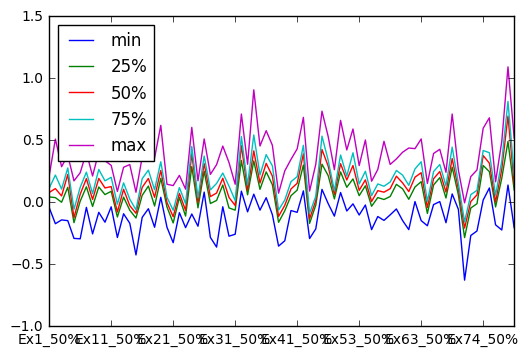

In [53]:
exon_counts = df.filter(regex=('Ex.+_count'))
subject_counts = exon_counts.T.describe().T

high_qual_subjects = df[(subject_counts['25%'] > 86) & (subject_counts['50%'] > 200)]
high_qual_exon_stats = high_qual_subjects.filter(regex=('_50%')).describe().T

# for item in ['25%', '50%', '75%']:
for item in high_qual_exon_stats.columns[3:]:
    high_qual_exon_stats[item].plot()
plt.legend(loc='best')

#### Get insert length stats for each exon

In [47]:
exon_outlier_marks = [['Exon', 'Read Count', '0.1% Cutoff', '99.9% Cutoff']]

exon_stats_dict = {}
for exon_index, insert_lengths in exon_insert_lengths.items():
    exon_upper = np.percentile(insert_lengths, 99.9)
    exon_lower = np.percentile(insert_lengths, 0.1)    
    if exon_index == 64:
        exon = '65/66'
    elif exon_index > 64:
        exon = exon_index + 2
    else:
        exon = exon_index + 1
    exon_outlier_marks.append([exon, len(insert_lengths), exon_lower, exon_upper])
    exon_stats_dict[exon_index] = [exon_lower, exon_upper]
    
#     clipped_exon_insert_lengths = [item for item in insert_lengths if 0 < item < 800]
#     plt.hist(clipped_exon_insert_lengths)
#     plt.title("Exon {} ({} reads)".format(exon, len(clipped_exon_insert_lengths)))
#     plt.xlabel("Insert Length")
#     plt.ylabel("Count")
#     plt.show()
print tabletext.to_text(exon_outlier_marks)

┌───────┬────────────┬─────────────┬──────────────┐
│ Exon  │ Read Count │ 0.1% Cutoff │ 99.9% Cutoff │
├───────┼────────────┼─────────────┼──────────────┤
│     1 │     206022 │        47.0 │        686.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     2 │      32373 │        53.0 │      682.256 │
├───────┼────────────┼─────────────┼──────────────┤
│     3 │      78665 │        45.0 │        698.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     4 │     120276 │      48.275 │        672.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     5 │      54335 │        47.0 │      679.332 │
├───────┼────────────┼─────────────┼──────────────┤
│     6 │      89717 │        48.0 │        681.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     7 │     138561 │        58.0 │        682.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     8 │     102512 │        47.0 │      678.489 │
├───────┼────────────┼─────────────┼──────────────┤
│     9 │   

#### Plot a histogram of all insert lengths across all exons

704.0 47.0


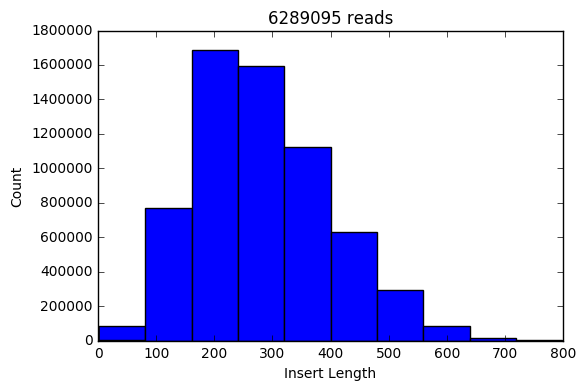

In [33]:
all_insert_lengths = list(itertools.chain(*exon_insert_lengths.values()))
print np.percentile(all_insert_lengths, 99.9), np.percentile(all_insert_lengths, 0.1)
# print np.percentile(all_insert_lengths, 0.1)
clipped_insert_lengths = [item for item in all_insert_lengths if 0 < item < 800]
bad_insert_lengths = [item for item in all_insert_lengths if item < 0 or item > 800]
# print len(bad_insert_lengths)

# Plot a histogram of distribution of insert lengths across all exons for each orientation
plt.hist(clipped_insert_lengths)
plt.title("{} reads".format(len(clipped_insert_lengths)))
plt.xlabel("Insert Length")
plt.ylabel("Count")
plt.show()